In [1]:
import os
from PIL.Image import Image
import numpy as np
import scipy.signal as scs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
from sklearn.model_selection import train_test_split
from typing import Optional, Tuple

In [2]:
%matplotlib inline
sns.set_style("whitegrid")

In [3]:
DATASET_PATH = os.path.join('.', 'dataset')
DATASET_PATH

'./dataset'

In [4]:
DRIVING_LOG_FILENAME = 'driving_log.csv'
DRIVING_LOG_PATH = os.path.join(DATASET_PATH, DRIVING_LOG_FILENAME)
DRIVING_LOG_PATH

'./dataset/driving_log.csv'

In [5]:
df = pd.read_csv(DRIVING_LOG_PATH, header=None, 
                 names=['Center Image', 'Left Image', 'Right Image', 
                        'Steering Angle', 
                        'Throttle', 'Brake', 'Speed'])
df.sample(n=10)

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Brake,Speed
3934,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,-0.694118,0.406072,0.0,12.007820
4785,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,0.000000,0.0,16.979460
9362,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,1.000000,0.0,30.190580
3407,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.635294,0.000000,0.0,10.039620
1642,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,0.000000,0.0,0.000256
5773,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,-0.023529,0.000000,0.0,14.661230
6382,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,1.000000,0.0,12.155290
6428,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,0.141705,0.0,16.032420
7577,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,0.000000,0.0,21.404430
2563,/home/markus/Desktop/Data/IMG/center_2018_10_0...,/home/markus/Desktop/Data/IMG/left_2018_10_07_...,/home/markus/Desktop/Data/IMG/right_2018_10_07...,0.000000,1.000000,0.0,30.186580


In [6]:
df.dtypes

Center Image       object
Left Image         object
Right Image        object
Steering Angle    float64
Throttle          float64
Brake             float64
Speed             float64
dtype: object

In [7]:
df['Steering Angle'] = df['Steering Angle'].astype(np.float32)
df['Throttle']       = df['Throttle'].astype(np.float32)
df['Brake']          = df['Brake'].astype(np.float32)
df['Speed']          = df['Speed'].astype(np.float32)

Let's see how the data is distributed. If, for example, only left turns were made (and no data augmentation is performed), a trained model would very likely be biased towards left turns.

We first define a helper function for plotting the data.

In [8]:
def histogram(series: pd.Series, name: str, label: str, filename: Optional[str]=None, bins: int=100):
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    series.hist(bins=bins, ax=axs[0])
    series.hist(bins=bins, log=10, ax=axs[1])
    f.suptitle('Distribution of {}'.format(name))
    axs[0].set_ylabel('Number of values')
    axs[0].set_xlabel(label)
    axs[1].set_ylabel('Number of values')
    axs[1].set_xlabel(label)
    sns.despine()
    if filename is not None:
        plt.savefig(os.path.join('examples', filename))

When we look at the steering angles, we quickly find that most of the steering angles appear to be exactly or very close to zero. The distribution of angles also seems to be slightly skewed to the left, which we will mitigate by mirroring the images during training. We can also see some minor spikes at both ends of the spectrum indicating that extreme angles were used much more often than moderate ones.

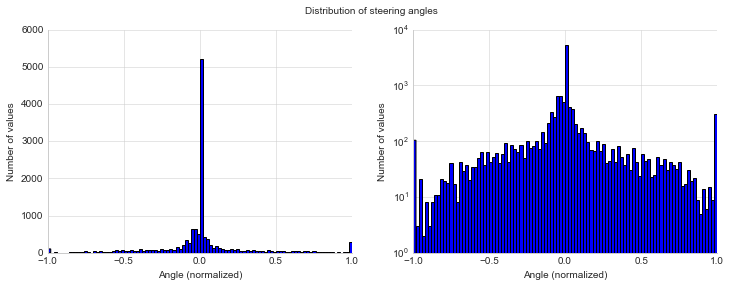

In [9]:
histogram(df['Steering Angle'], 'steering angles', 'Angle (normalized)', 'steering-angles.png')

Here's the number of occurrences and ranges numerically when using 100 bins as above:

In [10]:
counts, ranges = np.histogram(df['Steering Angle'], bins=100)
counts, ranges

(array([ 104,    3,   21,    2,    8,    3,    8,   11,   11,   21,   19,
          18,   41,   17,    8,   43,   29,   37,   20,   34,   34,   49,
          65,   38,   65,   43,   53,   62,   40,   58,   94,   42,   87,
          73,   65,   86,   49,   99,   76,   81,   99,   72,  149,   91,
         210,  336,  268,  644,  647,  494, 5205,  415,  371,  207,  139,
         174,  141,   95,   70,   68,  100,   68,   90,   41,   45,   73,
          42,   83,   52,   37,   59,   31,   77,   43,   24,   58,   44,
          47,   23,   25,   52,   37,   48,   31,   42,   38,   32,   42,
          16,   17,   31,   19,   22,    9,    5,   14,    6,   15,    9,
         303]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
        -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
        -0.28, -0.26, -0.24, -0.22

When we median filter the occurrences, we find that the peak gets replaced with a value of 494.

In [11]:
scs.medfilt(counts)

array([  3.,  21.,   3.,   8.,   3.,   8.,   8.,  11.,  11.,  19.,  19.,
        19.,  18.,  17.,  17.,  29.,  37.,  29.,  34.,  34.,  34.,  49.,
        49.,  65.,  43.,  53.,  53.,  53.,  58.,  58.,  58.,  87.,  73.,
        73.,  73.,  65.,  86.,  76.,  81.,  81.,  81.,  99.,  91., 149.,
       210., 268., 336., 644., 644., 647., 494., 415., 371., 207., 174.,
       141., 141.,  95.,  70.,  70.,  68.,  90.,  68.,  45.,  45.,  45.,
        73.,  52.,  52.,  52.,  37.,  59.,  43.,  43.,  43.,  44.,  47.,
        44.,  25.,  25.,  37.,  48.,  37.,  42.,  38.,  38.,  38.,  32.,
        17.,  17.,  19.,  22.,  19.,   9.,   9.,   6.,  14.,   9.,  15.,
         9.])

Given that this is about 10% of the original bin size, we'll be stochastically undersampling the "zero" angles by 90% (i.e. keep only randomly chosen 10% of the data) in order to prevent bias. 

In [12]:
494 / 5205

0.09490874159462055

When we look at the distribution of the absolute angles we find that the amounts appear to be log-linearly decreasing with increasing absolute angle, except for the peak at maximum angle. We could oversample angles with few occurrences, but given that these should be used only in extreme situations anyways, it might make sense to keep the distribution like that.

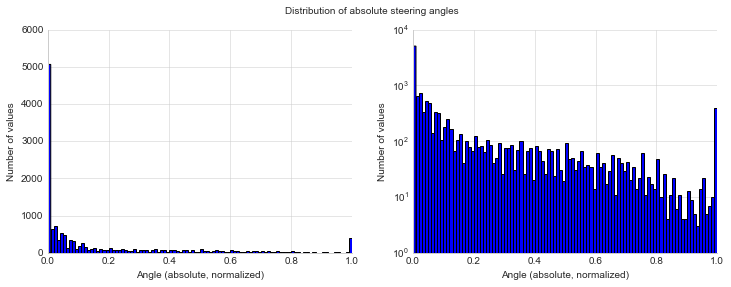

In [13]:
histogram(df['Steering Angle'].abs(), 'absolute steering angles', 'Angle (absolute, normalized)', bins=100)

When we look at the statistics of the absolute steering angles, we find that only 50% of the values are greater than about 0.04. Since the simulator steering angles range from `-25` to `25` (degrees, presumable), this would correspond to an angle of 0.88235 degrees (again, presumably).

In [14]:
df['Steering Angle'].abs().describe()

count    13462.000000
mean         0.165447
std          0.257141
min          0.000000
25%          0.000000
50%          0.035294
75%          0.223529
max          1.000000
Name: Steering Angle, dtype: float64

We see that for the extreme "angle" of `+1` we have more values, resulting in a mean value that is slightly positive, despite the "bump" on the negative side of the distribution.

In [15]:
df['Steering Angle'].describe()

count    13462.000000
mean         0.011312
std          0.305562
min         -1.000000
25%         -0.047059
50%          0.000000
75%          0.029412
max          1.000000
Name: Steering Angle, dtype: float64

As stated already, mirroring the image data during training will duplicate the number of examples and iron out these small issues. Even without that, the dataset appears to be balanced; care needs to be taken not to oversample the "zero" angles. As they make up for more than one third (about 36%) of the training data, this could introduce a severe bias.

In [16]:
sum(df['Steering Angle'] == 0) / len(df['Steering Angle'])

0.357673451195959

The throttle values show an entirely different picture: The values are either exactly zero or exactly one, indicating that the car was mostly standing still or driving at full speed during the training data collection. When looking at the log-transformed data, we see that there are indeed some values in between, but they are most likely sampled only during acceleration phases. We might want to undersample examples of zero throttle as we don't want the model to learn how to _not_ move.

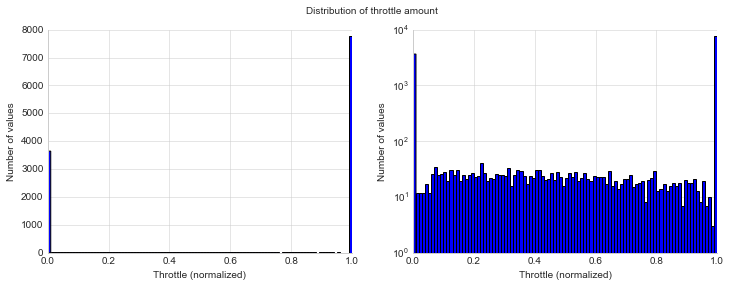

In [17]:
histogram(df['Throttle'], 'throttle amount', 'Throttle (normalized)', 'throttle-values.png')

The brake values appear are mostly zero. This makes sense: We already know the car was moving mostly at full speed, so the brake was only used for a fraction of the time.

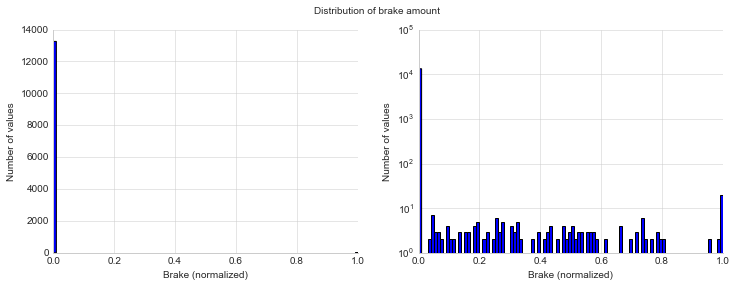

In [18]:
histogram(df['Brake'], 'brake amount', 'Brake (normalized)', 'brake-values.png')

Interestingly for the speeds we find a big amount of data distributed around 15 miles/hour. This might be due to data collection on the optional track: As that one is much harder to maneuver through, lower speeds were used there. The high spike for full speed corresponds to the high spike for full throttle. Zero speed situations are of no use to us.

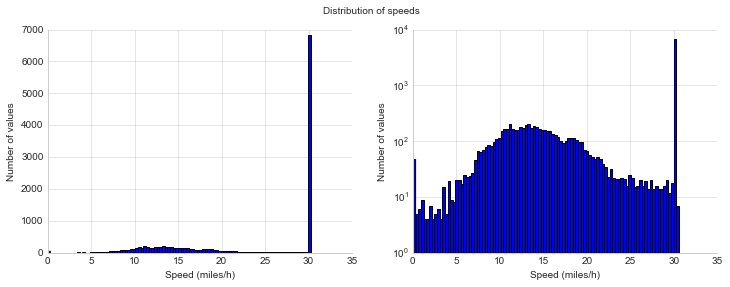

In [19]:
histogram(df['Speed'], 'speeds', 'Speed (miles/h)', 'speed-values.png')

## Sampling training data

We're going to sample data based on zero or nonzero steering angle.

In [20]:
zero_angles = (df['Steering Angle'] == 0)
sum(zero_angles)

4815

As stated before, we're generally only interested in rows with a positive speed.

In [21]:
positive_speed = (df['Speed'] > 0)
sum(positive_speed)

13462

We now split the dataset into two groups: Zero and nonzero steering angles.

In [22]:
sample_seed = 0
df_nonzero_angles = df[positive_speed & ~zero_angles]
df_zero_angles    = df[positive_speed & zero_angles]

We're going to split both sets into two groups once more: Training and validation data.

In [23]:
df_train_nonzero, df_valid_nonzero = train_test_split(df_nonzero_angles, 
                                                      test_size=0.3, random_state=sample_seed)
df_train_zero, df_valid_zero       = train_test_split(df_zero_angles, 
                                                      test_size=0.3, random_state=sample_seed)

We now split the validation set again into the actual validation set (used during training) and a test set (used to validate the final model).

In [24]:
df_test_nonzero, df_valid_nonzero = train_test_split(df_valid_nonzero, 
                                                     test_size=0.3, random_state=sample_seed)
df_test_zero, df_valid_zero       = train_test_split(df_valid_zero, 
                                                     test_size=0.3, random_state=sample_seed)

The "zero" training dataset still has too many elements. We're going to take a random sample of it for training.

In [25]:
zero_speed_factor = 0.1
zero_speed_count_train = int(zero_speed_factor * len(df_train_zero))
zero_speed_count_valid = int(zero_speed_factor * len(df_valid_zero))
zero_speed_count_test  = int(zero_speed_factor * len(df_test_zero))

In [26]:
df_train_zero = df_train_zero.sample(zero_speed_count_train, random_state=sample_seed)
df_valid_zero = df_valid_zero.sample(zero_speed_count_valid, random_state=sample_seed)
df_test_zero  = df_test_zero.sample(zero_speed_count_test, random_state=sample_seed)

Here's the actual size of the "nonzero" training, validation and test sets now:

In [27]:
len(df_train_nonzero), len(df_valid_nonzero), len(df_test_nonzero)

(6052, 779, 1816)

These are the counts of the "zero" sets:

In [28]:
len(df_train_zero), len(df_valid_zero), len(df_test_zero)

(337, 43, 101)

We now combine the data into the actual data sets used for training.

In [29]:
df_train = pd.concat([df_train_zero, df_train_nonzero])
df_valid = pd.concat([df_valid_zero, df_valid_nonzero])
df_test = pd.concat([df_test_zero, df_test_nonzero])
len(df_train), len(df_valid), len(df_test)

(6389, 822, 1917)

For the first iteration of training, we're only going to train with images from the center camera.

In [30]:
import keras

Using TensorFlow backend.


We'll be using a custom data generator as described in [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly).

In [45]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df: pd.DataFrame, batch_size: int=32, dim: Tuple[int, int]=(320, 160, 3), shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        rows = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(rows)

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, rows):
        """Generates data containing batch_size samples"""
        # Initialization
        width, height, channels = self.dim
        X = np.empty((self.batch_size, height, width, channels), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.float32)
        
        # Generate data
        for i, (idx, row) in enumerate(rows.iterrows()):
            # Store sample
            img = Image.open(row['Center Image']).convert('RGB')
            X[i,] = np.array(img).astype(np.float32) / 255.

            # Store angle
            y[i] = row['Steering Angle']

        return X, y

Let's test the generator:

In [46]:
test_generator = DataGenerator(df_train, batch_size=2)
print('Number of samples:', len(test_generator))

Number of samples: 3194


Let's enumerate some of the examples:

(2, 160, 320, 3) (2,)


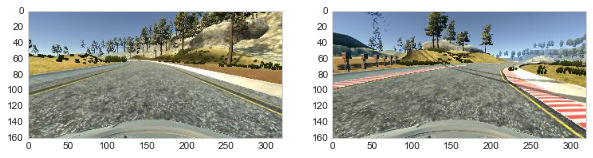

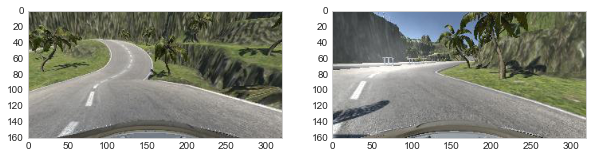

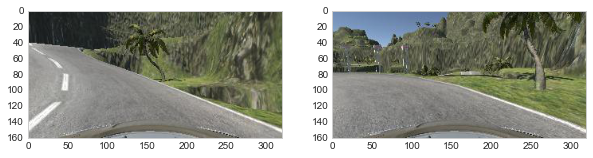

In [49]:
i = 0
for i, (X, y) in enumerate(test_generator):
    if i == 0:
        print(X.shape, y.shape)
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].imshow(X[0])
    axs[1].imshow(X[1])
    axs[0].grid(None)
    axs[1].grid(None)
    i += 1
    if i == 3:
        break